# Spam Classifier : SMS

### Load Libraries :

In [86]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
import matplotlib.pyplot as plt 

### Load Data :

In [30]:
def load_data(path):
    text, label =[], []
    with open(path) as file:
        for line in file:
            tokens = line.split()
            label.append(word2int[tokens[0]])
            text.append(' '.join(tokens[1:]))
    return [text, label]

In [31]:
word2int = {'ham':0, "spam":1}
int2word = {0:'ham', 1:"spam"}

X,y = load_data("C:/Users/ASUS/Downloads/Spam_or_not/data")

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_digit = tokenizer.texts_to_sequences(X)
X_digit = np.array(X_digit, dtype=object)
y = np.array(y)

In [33]:
y.shape

(5574,)

In [34]:
sen_length = 100
X_digit = pad_sequences(X_digit,maxlen= sen_length)
X_digit[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  799,  129,   67, 1691,  145,  108,  158, 1946,   21,    7,
         38,  339,   88,  903,   55,  115,  415,    3,   44,   12,   14,
         85, 1947,   46,  366,  961, 4438,    2,   68,  324,  232,    2,
       2999])

In [36]:
y = to_categorical(y)

### Split and Shuffle:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_digit, y, test_size = 0.25, random_state = 7)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (4180, 100)
X_test: (1394, 100)
y_train: (4180, 2)
y_test: (1394, 2)


### Generate Embedding

In [73]:
def generate_Embedding(tokenizer,dim):
    embedding = {}
    with open(f"C:/Users/ASUS/Downloads/Spam_or_not/glove.6B.{dim}d.txt",encoding='utf8') as file:
        for line in tqdm.tqdm(file, "Reading the Glove file"):
            tokens = line.split()
            word = tokens[0]
            vector = np.array(tokens[1:], dtype = 'float32')
            embedding[word] = vector
    wordI = tokenizer.word_index
    embedding_matrix = np.zeros((len(wordI)+1,dim))

    for word , index in wordI.items():
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[index] = vector
            
    return embedding_matrix

In [74]:
embedding_matrix = generate_Embedding(tokenizer,100)

Reading the Glove file: 400000it [00:09, 40080.93it/s]


In [72]:
embedding_matrix[tokenizer.word_index['go']]

array([-0.078894  ,  0.46160001,  0.57779002, -0.71636999, -0.13121   ,
        0.41859999, -0.29155999,  0.52006   ,  0.089986  , -0.35062   ,
        0.51754999,  0.51998001,  0.15218   ,  0.41485   , -0.12377   ,
       -0.37222001,  0.0273    ,  0.75673002, -0.8739    ,  0.58934999,
        0.46662   ,  0.62918001,  0.092603  , -0.012868  , -0.015169  ,
        0.25567001, -0.43024999, -0.77667999,  0.71449   , -0.38339999,
       -0.69638002,  0.23522   ,  0.11396   ,  0.02778   ,  0.071357  ,
        0.87409002, -0.12809999,  0.063576  ,  0.067867  , -0.50181001,
       -0.28523001, -0.072536  , -0.50738001, -0.69139999, -0.53579003,
       -0.11361   , -0.38234001, -0.12414   ,  0.011214  , -1.16219997,
        0.037057  , -0.18494999,  0.01416   ,  0.87193   , -0.097309  ,
       -2.35649991, -0.14554   ,  0.28275001,  2.00530005,  0.23439001,
       -0.38297999,  0.69538999, -0.44916001, -0.094157  ,  0.90526998,
        0.65763998,  0.27627999,  0.30688   , -0.57780999, -0.22

### Build LSTM model

In [77]:
def build_model(embedding_matrix, lstm_units):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                       weights = [embedding_matrix],
                       trainable = False,
                       input_length = sen_length))
    model.add(LSTM(lstm_units,recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(2,activation='softmax'))
    
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [78]:
model = build_model(embedding_matrix, 128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          901300    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1,018,806
Trainable params: 117,506
Non-trainable params: 901,300
_________________________________________________________________


### Train The Mode:

In [79]:
history= model.fit(X_train, y_train, validation_data =(X_test,y_test),batch_size=64, epochs=10, verbose=1)

Epoch 1/10
66/66 [==============================] - 13s 170ms/step - loss: 0.1941 - accuracy: 0.9239 - val_loss: 0.1032 - val_accuracy: 0.9663
Epoch 2/10
66/66 [==============================] - 11s 163ms/step - loss: 0.0782 - accuracy: 0.9761 - val_loss: 0.0846 - val_accuracy: 0.9692
Epoch 3/10
66/66 [==============================] - 11s 172ms/step - loss: 0.0683 - accuracy: 0.9766 - val_loss: 0.0737 - val_accuracy: 0.9792
Epoch 4/10
66/66 [==============================] - 11s 168ms/step - loss: 0.0489 - accuracy: 0.9844 - val_loss: 0.0671 - val_accuracy: 0.9778
Epoch 5/10
66/66 [==============================] - 11s 166ms/step - loss: 0.0405 - accuracy: 0.9871 - val_loss: 0.0707 - val_accuracy: 0.9756
Epoch 6/10
66/66 [==============================] - 11s 167ms/step - loss: 0.0348 - accuracy: 0.9900 - val_loss: 0.0801 - val_accuracy: 0.9770
Epoch 7/10
66/66 [==============================] - 11s 167ms/step - loss: 0.0438 - accuracy: 0.9868 - val_loss: 0.0741 - val_accuracy: 0.9756

### Report The Results:

In [83]:
report = history.history
report.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

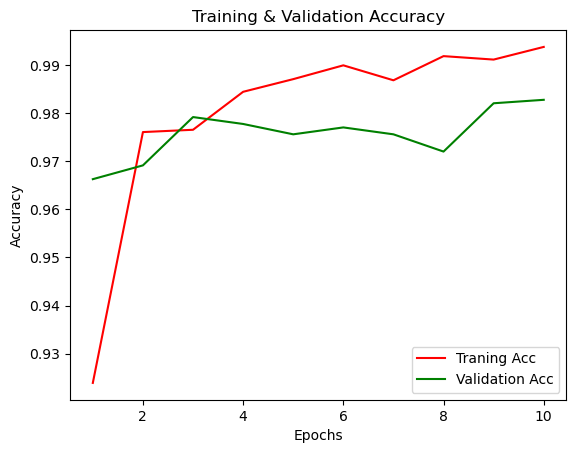

In [93]:
acc = report['accuracy']
val_acc = report['val_accuracy']

epochs =range(1,11)
plt.plot(epochs, acc, 'r',label = 'Traning Acc' )
plt.plot(epochs, val_acc, 'g', label = 'Validation Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right');

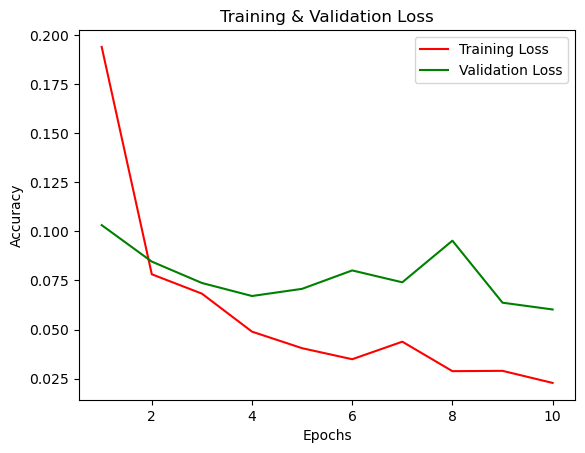

In [97]:
loss = report['loss']
val_loss = report['val_loss']

epochs =range(1,11)
plt.plot(epochs, loss, 'r',label = 'Training Loss' )
plt.plot(epochs, val_loss, 'g', label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend();

In [99]:
result = model.evaluate(X_test, y_test)
print(f". Accuracy :{result[1] * 100:.2f}%")

44/44 [==============================] - 1s 16ms/step - loss: 0.0602 - accuracy: 0.9828
. Accuracy :98.28%


### Testing

In [100]:
def prediction(model, sms):
    seq = tokenizer.texts_to_sequences([sms])
    seq = pad_sequences(seq, maxlen = sen_length)
    
    predict = model.predict(seq)[0]
    
    return int2word[np.argmax(predict)] 

In [107]:
prediction(model, 'I have been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.')

1/1 [==============================] - 0s 9ms/step


'ham'